<a href="https://colab.research.google.com/github/JulianaDamurie/AprendizagemDeMaquina/blob/main/knn_jnds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# import
import time
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import KFold, StratifiedKFold
import math
import scipy
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
from past.builtins import xrange
from collections import OrderedDict

In [36]:
class KNN:
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

        self.rAKNN = self.adaptive(X,y)
        
    def distance(self, X1, X2):
        distance = scipy.spatial.distance.euclidean(X1, X2)
        return distance

    def adaptive(self,X1,X2):
      d_a = {}
      len_data = X1.shape[0]
      epsilon = 0.0001

      all_distances = scipy.spatial.distance.cdist(X1, X1, 'euclidean')

      for i in range(len_data):
        r_max = math.inf
        for j in range(len_data):
          if X2[i] != X2[j]:
            r = all_distances[i][j] 
            if r < r_max:
              r_max = r 
        d_a[i] = (r_max - epsilon)
      return d_a
    
    def predict(self, X_test):
        final_output = []
        distances =  scipy.spatial.distance.cdist( self.X_train , X_test, 'euclidean')

        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(self.X_train)):
                dist = np.absolute(distances[j][i] / self.rAKNN[j])
                d.append([dist, j])
            d.sort()
            d = d[0:self.k]
            for d, j in d:
                votes.append(self.y_train[j])
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)
            
        return final_output
    
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        return (predictions == y_test).sum() / len(y_test)

In [38]:

# read first data set
dataset = True

if dataset:
  data, meta = arff.loadarff('/content/jm1.arff')

  df1 = pd.DataFrame(data)

  df1["defects"] = df1["defects"].astype(str).str.replace("b","")
  df1["defects"] = df1["defects"].astype(str).str.replace("'","")
else:
  data, meta = arff.loadarff('/content/kc2.arff')

  df1 = pd.DataFrame(data)

  df1["problems"] = df1["problems"].astype(str).str.replace("b","")
  df1["problems"] = df1["problems"].astype(str).str.replace("'","")
  df1["problems"] = df1["problems"].astype(str).str.replace("yes","true")
  df1["problems"] = df1["problems"].astype(str).str.replace("no","false")

df1 = df1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

df1

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,1.30,1.30,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,false
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,true
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,0.38,1279.39,51.0,10.0,8.0,1.0,17.0,36.0,112.0,86.0,13.0,true
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,1.45,4122.37,129.0,29.0,28.0,2.0,17.0,135.0,329.0,271.0,5.0,true
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,0.20,572.07,28.0,1.0,6.0,0.0,11.0,16.0,76.0,50.0,7.0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10880,18.0,4.0,1.0,4.0,52.0,241.48,0.14,7.33,32.93,1770.86,0.08,98.38,13.0,0.0,2.0,0.0,10.0,15.0,30.0,22.0,7.0,false
10881,9.0,2.0,1.0,2.0,30.0,129.66,0.12,8.25,15.72,1069.68,0.04,59.43,5.0,0.0,2.0,0.0,12.0,8.0,19.0,11.0,3.0,false
10882,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,0.17,762.04,29.0,1.0,10.0,0.0,18.0,15.0,59.0,44.0,7.0,false
10883,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,0.05,68.98,6.0,0.0,2.0,0.0,9.0,8.0,21.0,15.0,1.0,false


In [39]:
# divide into x_train, y_train, x_test and y_test

x_df1 = np.array(df1.iloc[:, :-1].values)
y_df1 = np.array(df1.iloc[:, 21].values)

In [40]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
scaler = StandardScaler()


In [41]:
k_list = [1,2,3,5,7,9,11,13,15]
dict_results_sem = {}
acc_peso = {}

for k in k_list :
  i = 0
  sum = 0 
  recall_true = 0
  recall_false = 0
  precision_true = 0
  precision_false = 0
  tempo_init = time.time()
  for train_index, test_index in  skf.split(x_df1,y_df1):
    xdf1_train, xdf1_test = x_df1[train_index], x_df1[test_index]
    ydf1_train, ydf1_test = y_df1[train_index], y_df1[test_index]

    scaler.fit(xdf1_train)

    xdf1_train = scaler.transform(xdf1_train)  
    xdf1_test = scaler.transform(xdf1_test) 

    classifier = KNeighborsClassifier(n_neighbors = k,weights="uniform")  
    classifier.fit(xdf1_train, ydf1_train)  
    
    tempo_treino = time.time() - tempo_init 
    tempo_init = time.time()

    ydf1_pred = classifier.predict(xdf1_test)

    #print(confusion_matrix(ydf1_test, ydf1_pred))  
    #print(classification_report(ydf1_test, ydf1_pred))
    dict_results_sem[k,i] = classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy']  

    sum += classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy'] 
    recall_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['recall']
    precision_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['precision']

    recall_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['recall']
    precision_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['precision']

    print("k------",k,i)
    print(classification_report(ydf1_test, ydf1_pred))
    i+=1
  tempo = time.time() - tempo_init 
  acc_peso[k,0] = [sum/5,k,"Sem peso",recall_true/5,precision_true/5,recall_false/5,precision_false/5,tempo_treino,tempo/5]


k------ 1 0
              precision    recall  f1-score   support

       false       0.85      0.85      0.85      1756
        true       0.38      0.38      0.38       420

    accuracy                           0.76      2176
   macro avg       0.61      0.61      0.61      2176
weighted avg       0.76      0.76      0.76      2176

k------ 1 1
              precision    recall  f1-score   support

       false       0.85      0.85      0.85      1756
        true       0.37      0.37      0.37       420

    accuracy                           0.76      2176
   macro avg       0.61      0.61      0.61      2176
weighted avg       0.76      0.76      0.76      2176

k------ 1 2
              precision    recall  f1-score   support

       false       0.86      0.84      0.85      1755
        true       0.40      0.44      0.42       421

    accuracy                           0.76      2176
   macro avg       0.63      0.64      0.64      2176
weighted avg       0.77      0.76     

In [42]:
k_list = [1,2,3,5,7,9,11,13,15]
dict_results = {}

for k in k_list :
  i = 0
  sum = 0 
  recall_true = 0
  recall_false = 0
  precision_true = 0
  precision_false = 0
  tempo_init = time.time()
  for train_index, test_index in  skf.split(x_df1,y_df1):
    xdf1_train, xdf1_test = x_df1[train_index], x_df1[test_index]
    ydf1_train, ydf1_test = y_df1[train_index], y_df1[test_index]

    scaler.fit(xdf1_train)

    xdf1_train = scaler.transform(xdf1_train)  
    xdf1_test = scaler.transform(xdf1_test) 

    classifier = KNeighborsClassifier(n_neighbors = k,weights="distance")  
    classifier.fit(xdf1_train, ydf1_train)  
    
    tempo_treino = time.time() - tempo_init 
    tempo_init = time.time()

    ydf1_pred = classifier.predict(xdf1_test)

    #print(confusion_matrix(ydf1_test, ydf1_pred))  
    #print(classification_report(ydf1_test, ydf1_pred))
    dict_results[k,i] = classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy']  

    sum += classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy'] 
    recall_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['recall']
    precision_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['precision']

    recall_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['recall']
    precision_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['precision']

    print("k------",k,i)
    print(classification_report(ydf1_test, ydf1_pred))
    i+=1
  tempo = time.time() - tempo_init 
  acc_peso[k,1] = [sum/5,k,"Com peso",recall_true/5,precision_true/5,recall_false/5,precision_false/5,tempo_treino,tempo/5]


k------ 1 0
              precision    recall  f1-score   support

       false       0.86      0.87      0.86      1756
        true       0.42      0.39      0.40       420

    accuracy                           0.78      2176
   macro avg       0.64      0.63      0.63      2176
weighted avg       0.77      0.78      0.77      2176

k------ 1 1
              precision    recall  f1-score   support

       false       0.84      0.85      0.85      1756
        true       0.36      0.34      0.35       420

    accuracy                           0.76      2176
   macro avg       0.60      0.60      0.60      2176
weighted avg       0.75      0.76      0.75      2176

k------ 1 2
              precision    recall  f1-score   support

       false       0.85      0.82      0.84      1755
        true       0.34      0.38      0.36       421

    accuracy                           0.74      2176
   macro avg       0.59      0.60      0.60      2176
weighted avg       0.75      0.74     

In [43]:
k_list = [1,2,3,5,7,9,11,13,15]
dict_results = {}

for k in k_list :
  i = 0
  sum = 0 
  recall_true = 0
  recall_false = 0
  precision_true = 0
  precision_false = 0
  tempo_init = time.time()
  for train_index, test_index in  skf.split(x_df1,y_df1):
    xdf1_train, xdf1_test = x_df1[train_index], x_df1[test_index]
    ydf1_train, ydf1_test = y_df1[train_index], y_df1[test_index]

    scaler.fit(xdf1_train)

    xdf1_train = scaler.transform(xdf1_train)  
    xdf1_test = scaler.transform(xdf1_test) 

    classifier = KNN(k)  
    classifier.fit(xdf1_train, ydf1_train)  
    
    tempo_treino = time.time() - tempo_init 
    tempo_init = time.time()

    ydf1_pred = classifier.predict(xdf1_test)

    #print(confusion_matrix(ydf1_test, ydf1_pred))  
    #print(classification_report(ydf1_test, ydf1_pred))
    dict_results[k,i] = classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy']  

    sum += classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy'] 
    recall_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['recall']
    precision_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['precision']

    recall_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['recall']
    precision_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['precision']

    print("k------",k,i)
    print(classification_report(ydf1_test, ydf1_pred))
    i+=1
  tempo = time.time() - tempo_init 
  acc_peso[k,2] = [sum/5,k,"Adaptativo",recall_true/5,precision_true/5,recall_false/5,precision_false/5,tempo_treino,tempo/5]



print(dict_results)

k------ 1 0
              precision    recall  f1-score   support

       false       0.84      0.86      0.85      1756
        true       0.36      0.33      0.35       420

    accuracy                           0.76      2176
   macro avg       0.60      0.60      0.60      2176
weighted avg       0.75      0.76      0.75      2176

k------ 1 1
              precision    recall  f1-score   support

       false       0.84      0.84      0.84      1756
        true       0.34      0.36      0.35       420

    accuracy                           0.74      2176
   macro avg       0.59      0.60      0.59      2176
weighted avg       0.75      0.74      0.75      2176

k------ 1 2
              precision    recall  f1-score   support

       false       0.84      0.83      0.84      1755
        true       0.33      0.34      0.33       421

    accuracy                           0.74      2176
   macro avg       0.58      0.59      0.58      2176
weighted avg       0.74      0.74     

In [66]:
df = pd.DataFrame.from_dict(acc_peso,orient='index',columns=['taxa de acerto','valor de k','k-NN',"recall true","precision true","recall false","precision false",'tempo treino',"tempo teste"])

In [67]:
df

,taxa de acerto,valor de k,k-NN,recall true,precision true,recall false,precision false,tempo treino,tempo teste
"(1, 0)",0.762408,1,Sem peso,0.376601,0.383676,0.854849,0.851326,0.597573,0.113210
"(2, 0)",0.805055,2,Sem peso,0.170238,0.489233,0.957161,0.828014,0.603905,0.114601
"(3, 0)",0.789798,3,Sem peso,0.311931,0.438786,0.904294,0.845805,0.657142,0.116684
"(5, 0)",0.804871,5,Sem peso,0.274843,0.491875,0.931868,0.842853,0.687573,0.120919
"(7, 0)",0.801562,7,Sem peso,0.240140,0.475636,0.936085,0.837174,0.678671,0.128460
"(9, 0)",0.805790,9,Sem peso,0.224451,0.497177,0.945086,0.835694,0.674853,0.133678
"(11, 0)",0.809926,11,Sem peso,0.202581,0.522340,0.955451,0.833348,0.669560,0.124197
"(13, 0)",0.805515,13,Sem peso,0.188285,0.492623,0.953400,0.830583,0.717855,0.124452
"(15, 0)",0.812408,15,Sem peso,0.191633,0.541623,0.961149,0.832294,0.668941,0.133016
"(1, 1)",0.757996,1,Com peso,0.364244,0.372686,0.852339,0.848364,0.564601,0.105333


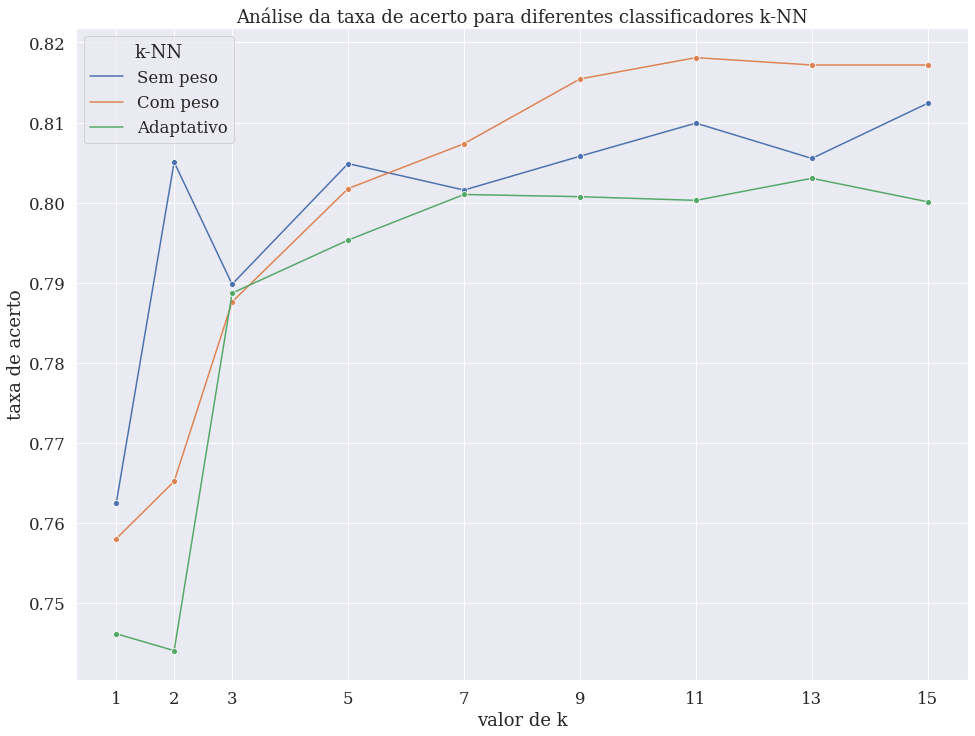

In [58]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="taxa de acerto",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title('Análise da taxa de acerto para diferentes classificadores k-NN')
plt.grid(True)  #just add this
plt.show()

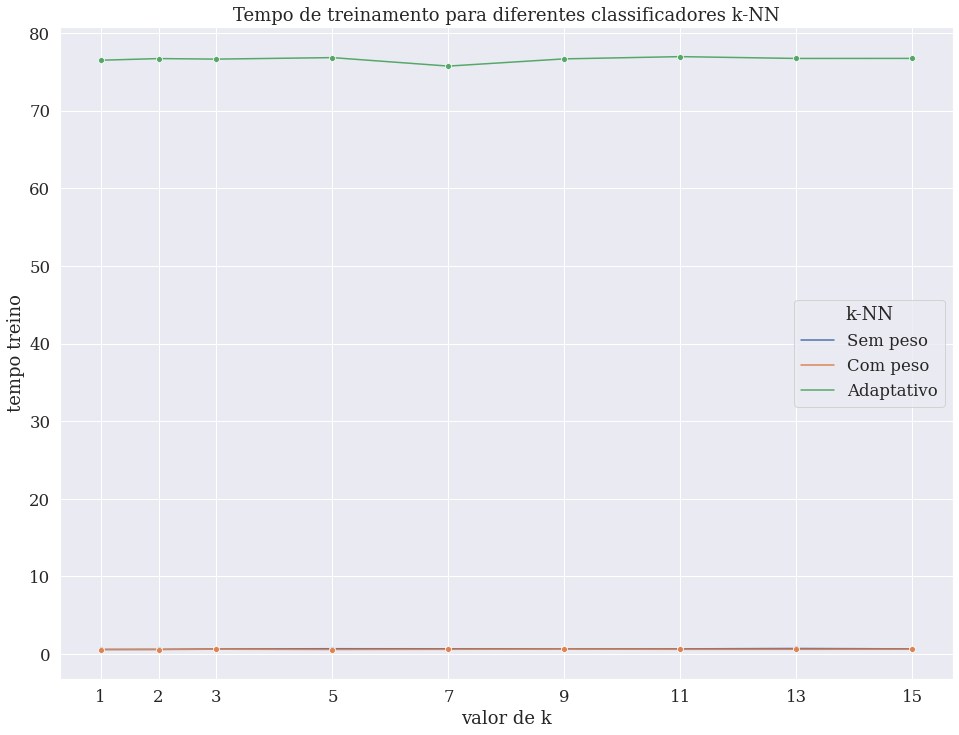

In [61]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="tempo treino",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title('Tempo de treinamento para diferentes classificadores k-NN')
plt.grid(True)  #just add this
plt.show()

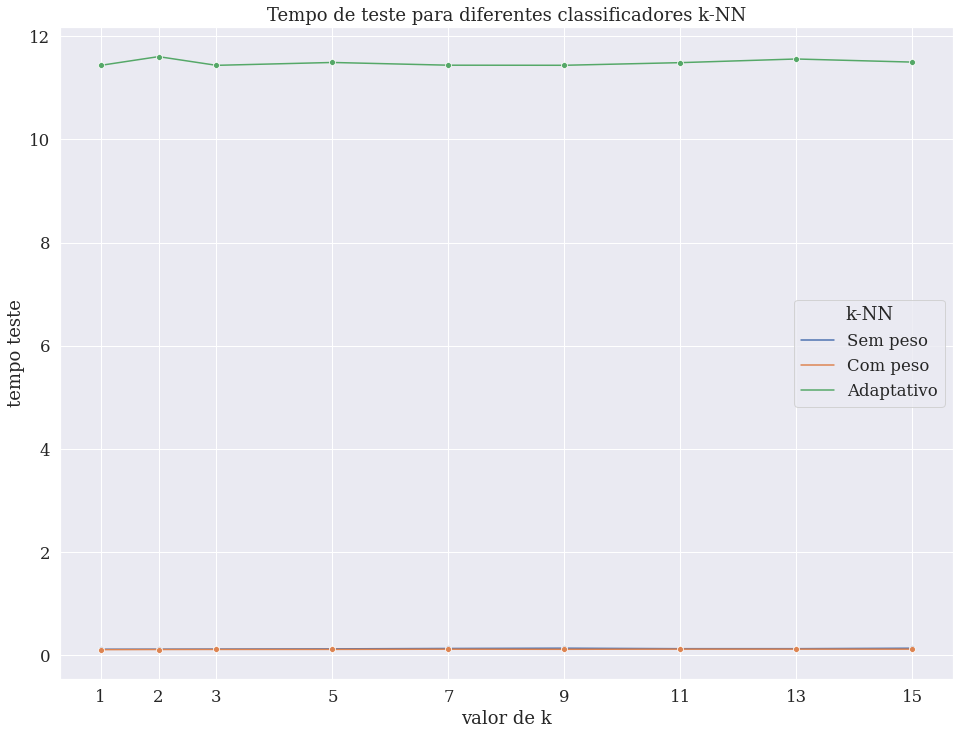

In [60]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="tempo teste",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title('Tempo de teste para diferentes classificadores k-NN')
plt.grid(True)  #just add this
plt.show()

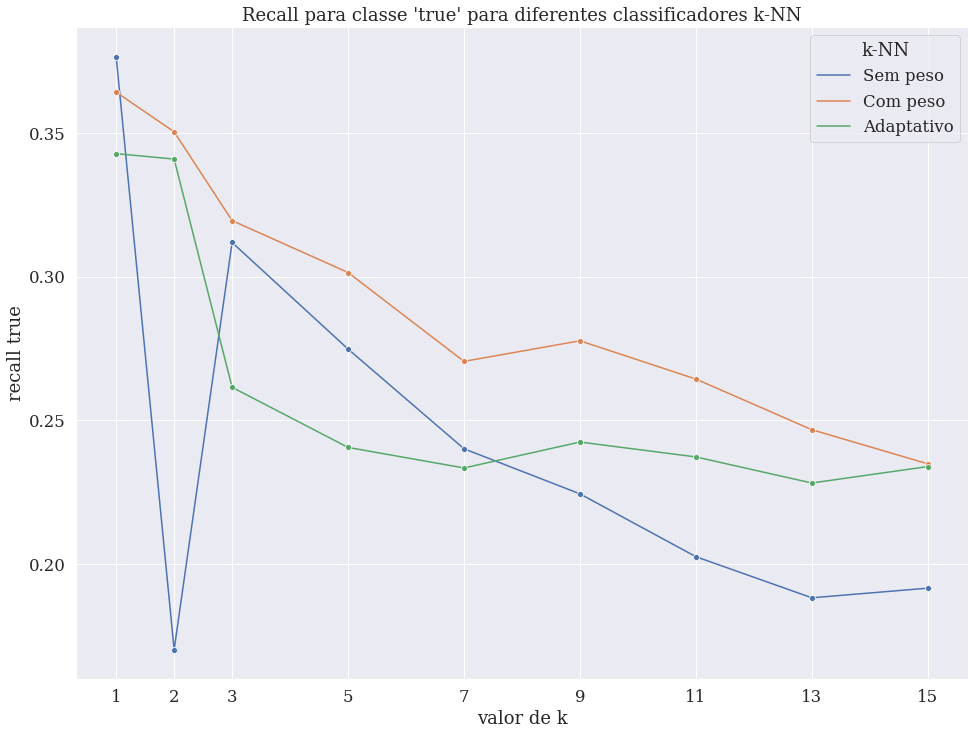

In [62]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="recall true",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title("Recall para classe 'true' para diferentes classificadores k-NN")
plt.grid(True)  #just add this
plt.show()

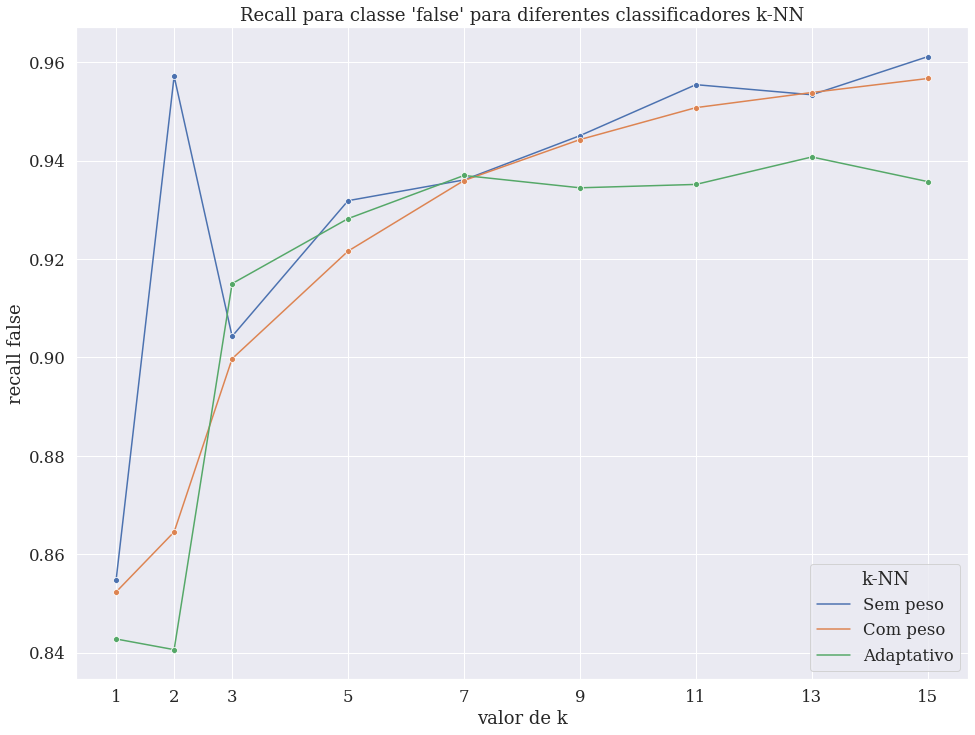

In [64]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="recall false",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title("Recall para classe 'false' para diferentes classificadores k-NN")
plt.grid(True)  #just add this
plt.show()

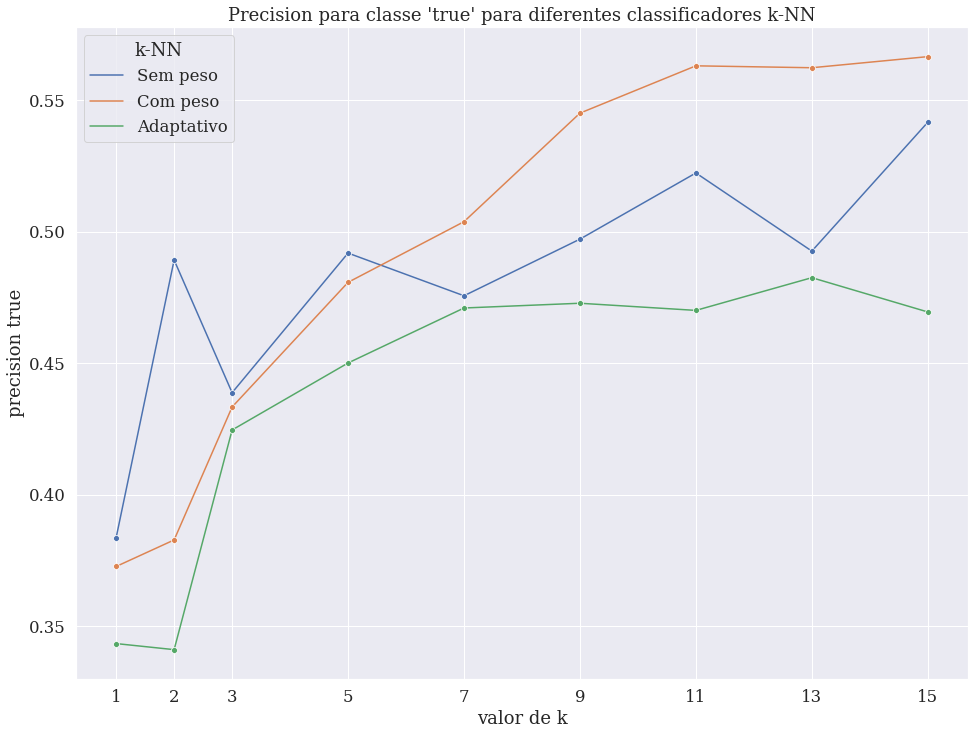

In [69]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="precision true",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title("Precision para classe 'true' para diferentes classificadores k-NN")
plt.grid(True)  #just add this
plt.show()

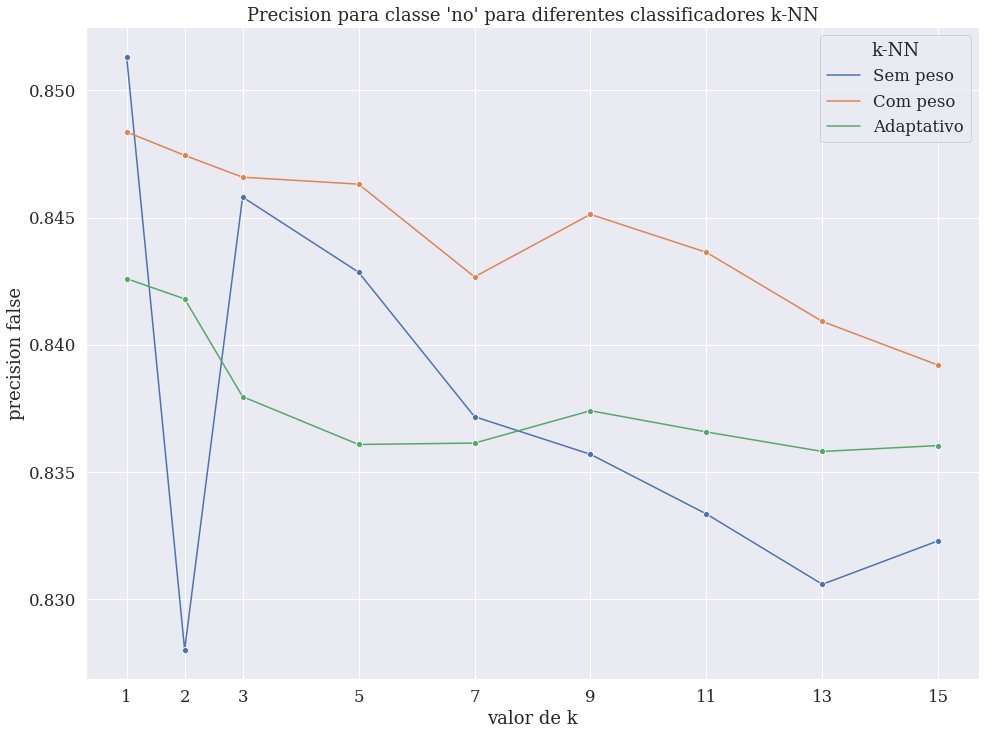

In [68]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="precision false",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title("Precision para classe 'no' para diferentes classificadores k-NN")
plt.grid(True)  #just add this
plt.show()